In [1]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from tensorflow.python.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.python.keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.python.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE

seed = 1
# # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
df = pd.read_csv("clean_train.csv")

In [3]:
def label(df):
    # label data
    df['LABEL'] = 0
    df.loc[df['CATEGORY'] == '1 0 0 0', 'LABEL'] = 0
    df.loc[df['CATEGORY'] == '0 1 0 0', 'LABEL'] = 1
    df.loc[df['CATEGORY'] == '0 0 1 0', 'LABEL'] = 2
    df.loc[df['CATEGORY'] == '0 0 0 1', 'LABEL'] = 3
    df.loc[df['CATEGORY'] == '0 1 1 0', 'LABEL'] = 4


def preprocess(df):
    n_most_common_words = 1600
    max_len = 100  #the length of opcode

    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=n_most_common_words, lower=False)

    # tokenizer.fit_on_texts(increased_vul['OPCODE'].values)
    tokenizer.fit_on_texts(df['OPCODE'].values)
    sequences = tokenizer.texts_to_sequences(df['OPCODE'].values)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    X = tf.keras.utils.pad_sequences(sequences, maxlen=max_len)
    return X


def dftoXY(df):
    X_test = preprocess(df)
    label(df)
    print(pd.value_counts(df['LABEL']))
    y_test = tf.keras.utils.to_categorical(df['LABEL'], num_classes=5)
    return X_test, y_test


def XandY(sp_df, g_df, p_df, s_df, n_df):
    dfset = pd.concat([sp_df, g_df, p_df, s_df, n_df])
    dfset = dfset.sample(frac=1, random_state=39, replace=False)

    dfset['LABEL'] = 0

    dfset.loc[dfset['CATEGORY'] == '1 0 0 0', 'LABEL'] = 0
    dfset.loc[dfset['CATEGORY'] == '0 1 0 0', 'LABEL'] = 1
    dfset.loc[dfset['CATEGORY'] == '0 0 1 0', 'LABEL'] = 2
    dfset.loc[dfset['CATEGORY'] == '0 0 0 1', 'LABEL'] = 3
    dfset.loc[dfset['CATEGORY'] == '0 1 1 0', 'LABEL'] = 4

    X, y = dftoXY(dfset)

    print('Shape of X: {}'.format(X.shape))

    y_labels = np.expand_dims(np.array(np.argmax(y, axis=1)), axis=1)
    print('Shape of y: {}'.format(y_labels.shape))

    return X, y_labels

In [4]:
data = df
pd.value_counts(data['CATEGORY'])

1 0 0 0    884273
0 0 0 1      5801
0 0 1 0      1461
0 1 0 0      1207
0 1 1 0       171
Name: CATEGORY, dtype: int64

In [5]:
data_plots = data
data_plots = data_plots.replace({'CATEGORY': {'1 0 0 0': 'normal', '0 1 0 0': 'suicidal', '0 0 1 0': 'prodigal',
                                              '0 0 0 1': 'greedy', '0 1 1 0': 'suicidal and prodigal'}})
data_plots.head()

,ADDRESS,OPCODE,CATEGORY
0,0x219f4ee903f78e78773e5d1e3520cfd507485bc6,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,normal
1,0x560ed796aa8d23411b94b9d047ecdda39d4fcdeb,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,normal
2,0xe726f97ff3c63dd71c1520c102adc39d1a2693ea,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,normal
3,0x8ebac490495958b3804bb079e259340f0f53b69c,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,normal
4,0x190700d69031db6b072a30577f9b3dbc53a320a1,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,normal


In [6]:
shuffled = data

# shuffled = data
n = shuffled[shuffled['CATEGORY'] == '1 0 0 0']  # no vulnerabilities
s = shuffled[shuffled['CATEGORY'] == '0 1 0 0']  # suicidal
p = shuffled[shuffled['CATEGORY'] == '0 0 1 0']  # prodigal
g = shuffled[shuffled['CATEGORY'] == '0 0 0 1']  # greedy
sp = shuffled[shuffled['CATEGORY'] == '0 1 1 0']  # suicidal and prodigal

In [7]:
proportion_train = 0.7
proportion_val = 0.1
proportion_test = 0.2

#n
n_shuf = n.sample(frac=1, random_state=39, replace=False)
# set number of samples in each set
num_n_train = 10000
num_n_val = round(((num_n_train) / proportion_train) * proportion_val)
num_n_test = round(((num_n_train) / proportion_train) * proportion_test)
n_train = n_shuf.iloc[0:num_n_train]
n_val = n_shuf.iloc[num_n_train:(num_n_train + num_n_val)]
n_test = n_shuf.iloc[(num_n_train + num_n_val):(num_n_train + num_n_val + num_n_test)]

#s
s_shuf = s.sample(frac=1, random_state=39, replace=False)
num_s_train = round(len(s_shuf) * proportion_train)
num_s_val = round(len(s_shuf) * proportion_val)
s_train = s_shuf.iloc[0:num_s_train]
s_val = s_shuf.iloc[num_s_train:(num_s_train + num_s_val)]
s_test = s_shuf.iloc[(num_s_train + num_s_val):]

#p
p_shuf = p.sample(frac=1, random_state=39, replace=False)
num_p_train = round(len(p_shuf) * proportion_train)
num_p_val = round(len(p_shuf) * proportion_val)
p_train = p_shuf.iloc[0:num_p_train]
p_val = p_shuf.iloc[num_p_train:(num_p_train + num_p_val)]
p_test = p_shuf.iloc[(num_p_train + num_p_val):]

#g
g_shuf = g.sample(frac=1, random_state=39, replace=False)
num_g_train = round(len(g_shuf) * proportion_train)
num_g_val = round(len(g_shuf) * proportion_val)
g_train = g_shuf.iloc[0:num_g_train]
g_val = g_shuf.iloc[num_g_train:(num_g_train + num_g_val)]
g_test = g_shuf.iloc[(num_g_train + num_g_val):]

#sp
sp_shuf = sp.sample(frac=1, random_state=39, replace=False)
num_sp_train = round(len(sp_shuf) * proportion_train)
num_sp_val = round(len(sp_shuf) * proportion_val)
sp_train = sp_shuf.iloc[0:num_sp_train]
sp_val = sp_shuf.iloc[num_sp_train:(num_sp_train + num_sp_val)]
sp_test = sp_shuf.iloc[(num_sp_train + num_sp_val):]
#====train set
df_train = pd.concat([sp_train, n_train, g_train, p_train, s_train])
df_train = df_train.sample(frac=1, random_state=39, replace=False)
df_train['LABEL'] = 0

df_train['LABEL'] = 0

#One-hot encode the lab
df_train.loc[df_train['CATEGORY'] == '1 0 0 0', 'LABEL'] = 0
df_train.loc[df_train['CATEGORY'] == '0 1 0 0', 'LABEL'] = 1
df_train.loc[df_train['CATEGORY'] == '0 0 1 0', 'LABEL'] = 2
df_train.loc[df_train['CATEGORY'] == '0 0 0 1', 'LABEL'] = 3
df_train.loc[df_train['CATEGORY'] == '0 1 1 0', 'LABEL'] = 4

X_train, y_train = dftoXY(df_train)
df_train

Found 150 unique tokens.
0    10000
3     4061
2     1023
1      845
4      120
Name: LABEL, dtype: int64


,ADDRESS,OPCODE,CATEGORY,LABEL
715961,0x47de7ffe3326563d3fa6b62ea80cfcc3994b384e,60 60 52 60 35 7c 90 04 80 63 14 61 57 80 63 1...,0 0 0 1,3
448833,0x3d4329d6fc242db50bb615f761205c2ee9d736dd,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0,0
614956,0xcf561870a989d3a91d4e7a4d737c9a2ed743a918,60 60 52 60 60 0a 60 35 04 63 81 14 60 57 5b 6...,1 0 0 0,0
435752,0x88b377f0a074e61fbf2e1ed87e96b1ac861dca69,60 60 52 36 15 60 57 60 56 5b 60 5b 5b 56 5b 00,0 0 0 1,3
489795,0xd949e0532ead676a75ab3745b8567f2736bc61ab,60 60 52 60 60 0a 60 35 04 63 81 14 60 57 5b 6...,1 0 0 0,0
...,...,...,...,...
743404,0x86d12281c3afe53ea62b4156d883673b29b62074,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0,0
821450,0xd5ec1fb9571933913f4928e3e0a44127115742aa,60 60 52 63 7c 60 35 04 16 63 81 14 61 57 80 6...,1 0 0 0,0
35612,0xa9c5e05701211f5e93dba45f51636fdf338b083e,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0,0
169135,0x504b30409026002780a587d481b85aaae05339c9,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0,0


In [8]:
#====train set
df_train = pd.concat([sp_train, n_train, g_train, p_train, s_train])
df_train = df_train.sample(frac=1, random_state=39, replace=False)
df_train['LABEL'] = 0

#One-hot encoding
df_train.loc[df_train['CATEGORY'] == '1 0 0 0', 'LABEL'] = 0
df_train.loc[df_train['CATEGORY'] == '0 1 0 0', 'LABEL'] = 1
df_train.loc[df_train['CATEGORY'] == '0 0 1 0', 'LABEL'] = 2
df_train.loc[df_train['CATEGORY'] == '0 0 0 1', 'LABEL'] = 3
df_train.loc[df_train['CATEGORY'] == '0 1 1 0', 'LABEL'] = 4

X_train, y_train = dftoXY(df_train)

print('Shape of X: {}'.format(X_train.shape))

# for sm.fit_sample
ytrain_labels = np.expand_dims(np.array(np.argmax(y_train, axis=1)), axis=1)
print('Shape of y: {}'.format(ytrain_labels.shape))

# ============ validation set ============
df_val = pd.concat([sp_val, n_val, g_val, p_val, s_val])
df_val = df_val.sample(frac=1, random_state=39, replace=False)

df_val['LABEL'] = 0

#One-hot encoding
df_val.loc[df_val['CATEGORY'] == '1 0 0 0', 'LABEL'] = 0
df_val.loc[df_val['CATEGORY'] == '0 1 0 0', 'LABEL'] = 1
df_val.loc[df_val['CATEGORY'] == '0 0 1 0', 'LABEL'] = 2
df_val.loc[df_val['CATEGORY'] == '0 0 0 1', 'LABEL'] = 3
df_val.loc[df_val['CATEGORY'] == '0 1 1 0', 'LABEL'] = 4

X_val, y_val = dftoXY(df_val)

print('Shape of X: {}'.format(X_val.shape))

# for sm.fit_sample
yval_labels = np.expand_dims(np.array(np.argmax(y_val, axis=1)), axis=1)
print('Shape of y: {}'.format(yval_labels.shape))

# ============ test set ============
df_test = pd.concat([sp_test, n_test, g_test, p_test, s_test])
df_test = df_test.sample(frac=1, random_state=39, replace=False)

df_test['LABEL'] = 0

#One-hot encoding
df_test.loc[df_test['CATEGORY'] == '1 0 0 0', 'LABEL'] = 0
df_test.loc[df_test['CATEGORY'] == '0 1 0 0', 'LABEL'] = 1
df_test.loc[df_test['CATEGORY'] == '0 0 1 0', 'LABEL'] = 2
df_test.loc[df_test['CATEGORY'] == '0 0 0 1', 'LABEL'] = 3
df_test.loc[df_test['CATEGORY'] == '0 1 1 0', 'LABEL'] = 4

# df_train.head()

X_test, y_test = dftoXY(df_test)

print('Shape of X: {}'.format(X_test.shape))

# for sm.fit_sample
ytest_labels = np.expand_dims(np.array(np.argmax(y_test, axis=1)), axis=1)
print('Shape of y: {}'.format(ytest_labels.shape))


Found 150 unique tokens.
0    10000
3     4061
2     1023
1      845
4      120
Name: LABEL, dtype: int64
Shape of X: (16049, 100)
Shape of y: (16049, 1)
Found 150 unique tokens.
0    1429
3     580
2     146
1     121
4      17
Name: LABEL, dtype: int64
Shape of X: (2293, 100)
Shape of y: (2293, 1)
Found 150 unique tokens.
0    2857
3    1160
2     292
1     241
4      34
Name: LABEL, dtype: int64
Shape of X: (4584, 100)
Shape of y: (4584, 1)


In [9]:
# train set
X_train, ytrain_labels = XandY(sp_train, n_train, g_train, p_train, s_train)
# validation set
X_val, yval_labels = XandY(sp_val, n_val, g_val, p_val, s_val)
# test set
X_test, ytest_labels = XandY(sp_test, n_test, g_test, p_test, s_test)

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=17)
X_train_res, y_train_res = sm.fit_resample(X_train, ytrain_labels.ravel())
X_val_res, y_val_res = sm.fit_resample(X_val, yval_labels.ravel())
X_test_res, y_test_res = sm.fit_resample(X_test, ytest_labels.ravel())

Found 150 unique tokens.
0    10000
3     4061
2     1023
1      845
4      120
Name: LABEL, dtype: int64
Shape of X: (16049, 100)
Shape of y: (16049, 1)
Found 150 unique tokens.
0    1429
3     580
2     146
1     121
4      17
Name: LABEL, dtype: int64
Shape of X: (2293, 100)
Shape of y: (2293, 1)
Found 150 unique tokens.
0    2857
3    1160
2     292
1     241
4      34
Name: LABEL, dtype: int64
Shape of X: (4584, 100)
Shape of y: (4584, 1)


In [10]:
df = pd.DataFrame(np.concatenate([X_train_res, X_val_res, X_test_res]))
y = pd.DataFrame(np.concatenate([y_train_res, y_val_res, y_test_res]))
df_train, df_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=42)

In [11]:
df_test

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
63063,3,3,43,5,4,1,25,1,25,1,...,26,2,26,12,59,9,1,12,6,43
40480,8,3,1,8,30,7,16,20,11,1,...,3,6,18,6,34,21,9,73,6,18
55539,15,5,3,9,19,11,33,17,6,17,...,2,3,12,5,1,1,3,14,5,17
40003,0,0,0,0,0,0,0,0,0,0,...,27,2,3,1,18,6,13,2,3,18
9232,1,1,15,1,8,11,1,15,20,1,...,2,64,6,3,3,3,3,18,6,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47786,18,1,35,9,29,41,1,31,1,12,...,3,25,12,3,3,17,6,3,2,18
68728,8,7,11,1,7,2,7,11,1,8,...,1,13,6,12,14,1,62,3,3,19
48132,22,1,4,15,12,4,9,1,1,15,...,13,1,8,13,2,1,8,2,4,18
14125,4,10,1,5,31,6,21,2,3,5,...,3,3,14,14,51,57,29,12,93,14


In [12]:
import joblib

loaded_model = joblib.load("outputs_2/KNeighborsClassifier.joblib")
result = loaded_model.predict(df_test)

C:\Users\amezina\anaconda3\envs\tf210\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\amezina\anaconda3\envs\tf210\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RandomizedSearchCV from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [13]:
filtered_df = df_test.copy()

filtered_df["label"] = y_test
filtered_df["predicted"] = result

filtered_df = filtered_df[filtered_df['predicted'] != 0]

In [14]:
filtered_df

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,label,predicted
63063,3,3,43,5,4,1,25,1,25,1,...,26,12,59,9,1,12,6,43,1,1
40480,8,3,1,8,30,7,16,20,11,1,...,18,6,34,21,9,73,6,18,4,1
55539,15,5,3,9,19,11,33,17,6,17,...,12,5,1,1,3,14,5,17,3,1
40003,0,0,0,0,0,0,0,0,0,0,...,3,1,18,6,13,2,3,18,3,1
20602,80,3,3,3,3,3,3,3,3,3,...,2,13,26,37,50,59,61,18,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15271,66,2,11,2,7,8,40,2,11,1,...,3,3,3,3,3,3,3,18,1,1
32485,1,8,5,20,21,9,7,11,1,8,...,3,3,3,3,6,3,3,18,2,1
47786,18,1,35,9,29,41,1,31,1,12,...,12,3,3,17,6,3,2,18,4,1
48132,22,1,4,15,12,4,9,1,1,15,...,8,13,2,1,8,2,4,18,4,1


In [15]:
df_test_2 = filtered_df.drop(columns=["label", "predicted"])
y_test_2 = filtered_df["label"]

In [16]:
import joblib

loaded_model = joblib.load("outputs_4/SVC.joblib")
result_2 = loaded_model.predict(df_test_2)

C:\Users\amezina\anaconda3\envs\tf210\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVC from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\amezina\anaconda3\envs\tf210\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RandomizedSearchCV from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [17]:
from sklearn.metrics import f1_score, precision_score, recall_score, balanced_accuracy_score, roc_auc_score


def accuracies(y_pred, y_test):
    y_test = y_test.reset_index(drop=True)
    # y_pred = y_pred.to_numpy()
    normal_correct = 0
    suicidal_correct = 0
    prodigal_correct = 0
    greedy_correct = 0
    suicidal_prodigal_correct = 0

    normal_quantity = 0
    suicidal_quantity = 0
    prodigal_quantity = 0
    greedy_quantity = 0
    suicidal_prodigal_quantity = 0
    false_negative = 0

    for i in range(0, len(y_test)):
        if y_pred[i] == y_test[i] and y_test[i] == 0:
            normal_correct = normal_correct + 1
        if y_pred[i] == y_test[i] and y_test[i] == 1:
            suicidal_correct = suicidal_correct + 1
        if y_pred[i] == y_test[i] and y_test[i] == 2:
            prodigal_correct = prodigal_correct + 1
        if y_pred[i] == y_test[i] and y_test[i] == 3:
            greedy_correct = greedy_correct + 1
        if y_pred[i] == y_test[i] and y_test[i] == 4:
            suicidal_prodigal_correct = suicidal_prodigal_correct + 1

        if y_test[i] == 0:
            normal_quantity = normal_quantity + 1
        if y_test[i] == 1:
            suicidal_quantity = suicidal_quantity + 1
        if y_test[i] == 2:
            prodigal_quantity = prodigal_quantity + 1
        if y_test[i] == 3:
            greedy_quantity = greedy_quantity + 1
        if y_test[i] == 4:
            suicidal_prodigal_quantity = suicidal_prodigal_quantity + 1

        if y_test[i] != 0 and y_pred[i] == 0:
            false_negative = false_negative + 1

    # print('normal accuracy:', normal_correct / normal_quantity)
    print('suicidal accuracy:', suicidal_correct / suicidal_quantity)
    print('prodigal accuracy:', prodigal_correct / prodigal_quantity)
    print('greedy accuracy:', greedy_correct / greedy_quantity)
    print('suicidal and prodigal accuracy', suicidal_prodigal_correct / suicidal_prodigal_quantity)
    print(normal_quantity, suicidal_quantity, prodigal_quantity, greedy_quantity, suicidal_prodigal_quantity)

    print('false negative:', false_negative / (
            suicidal_quantity + prodigal_quantity + greedy_quantity + suicidal_prodigal_quantity))

suicidal accuracy: 0.9988165680473373
prodigal accuracy: 0.9943000455996353
greedy accuracy: 0.9927553166627717
suicidal and prodigal accuracy 0.9987415051598288
67 4225 4386 4279 3973
false negative: 0.0


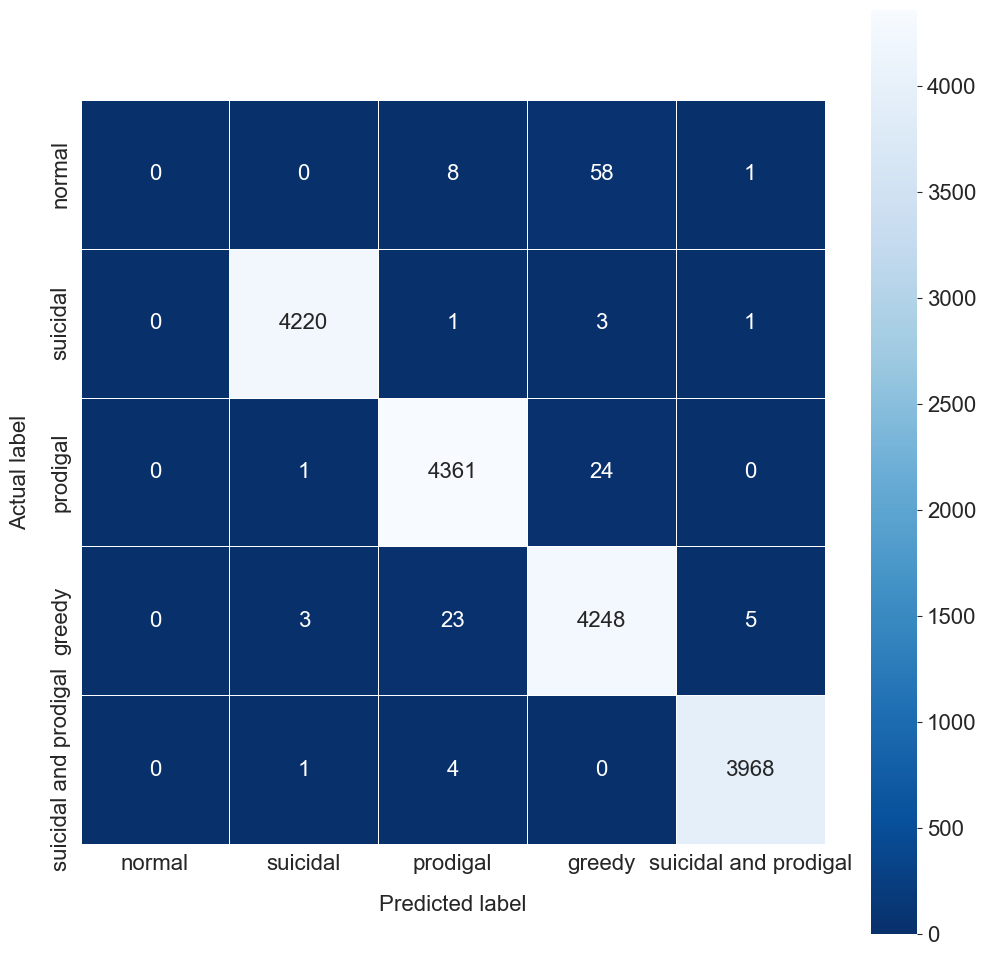

C:\Users\amezina\anaconda3\envs\tf210\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
from joblib import dump
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
import seaborn as sns

accuracies(result_2, y_test_2)
cm = confusion_matrix(y_test_2, result_2)
x_axis_labels = ["normal", "suicidal", "prodigal", "greedy", "suicidal and prodigal"]
# Plot confusion matrix
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, annot=True, xticklabels=x_axis_labels, yticklabels=x_axis_labels, fmt="g", linewidths=.5, square=True, cmap='Blues_r', annot_kws={"size": 16})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Actual label', fontsize=16, labelpad=15)
plt.xlabel('Predicted label', fontsize=16, labelpad=15)
plt.savefig(f'confmatrix_2_scenario.pdf')
plt.show()
report = pd.DataFrame(columns=['Accuracy'], data=[0])
report['F1'] = f1_score(y_test_2, result_2, average="weighted")
report['Precision'] = precision_score(y_test_2, result_2, average="weighted")
report['Recall'] = recall_score(y_test_2, result_2, average="weighted")
report['Accuracy'] = loaded_model.score(df_test_2, y_test_2)
report['Balanced Acc'] = balanced_accuracy_score(y_test_2, result_2)

In [19]:
report

,Accuracy,F1,Precision,Recall,Balanced Acc
0,0.992144,0.990189,0.988255,0.992144,0.796923
